**由于本地没有可用的gpu资源以及kaggle kernels gpu的时长限制，故借本次比赛的机会学习使用TPU进行训练与推理**

该代码主要依据Araik Tamazian的notebook [FC Ensemble External Data (EffNet+DenseNet)](https://www.kaggle.com/atamazian/fc-ensemble-external-data-effnet-densenet) 进行改写

同时也参考了以下内容：
* [simple resnet baseline](https://www.kaggle.com/nekokiku/simple-resnet-baseline) by Neko Kiku
* [del_duplicate_image](https://github.com/seefun/TorchUtils/blob/master/torch_utils/dataset/del_duplicate_image.py) by seefun
* [Getting started with 100+ flowers on TPU](https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu) by Martine Goerner
* [TPU Flowers](https://www.kaggle.com/tusharkendre/tpu-flowers) by Tushar Kendre and Shreyaansh Gupta (random_blockout augmentation)
* [TPU: ENet B7 + DenseNet](https://www.kaggle.com/wrrosa/tpu-enet-b7-densenet) by Wojtek Rosa

对以上作者的无私分享表示由衷的感谢！



本notebook可在kaggle kernels的TPU环境下实现一键跑通，并在private test上获得0.988左右的成绩。如果大家再选择不同的模型组合，训练策略以及数据增强方法进行训练与推理，最终对多个结果采取投票的方法进行融合，成绩可达0.989-0.990+。关于投票的代码在其他小伙伴分享的notebook中已有详细的实现，这里就不再赘述了。

在本次比赛中并未使用太多的数据增强方法，也还没来得及尝试沐神的ResNeSt，所以还是有很大的提升空间的，欢迎大家进行魔改，也希望大家多多分享改进方案。

**<span style="color:blue">第一次分享notebook，大家有什么意见尽管提；如果对大家有帮助，也请各位不要吝啬vote呀，哈哈哈</span>**

In [1]:
!pip install -q efficientnet

In [2]:
import math, re, os, random
import tensorflow as tf
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
import numpy as np
import pandas as pd
import gc
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

print("TF version " + tf.__version__)

TF version 2.4.1


# TPU detection

In [3]:
AUTO = tf.data.experimental.AUTOTUNE

# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  8


# Configuration

In [4]:
IMAGE_SIZE = [224, 224]
EPOCHS = 60
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# Data access and classes

TPUs read data directly from Google Cloud Storage (GCS), so we need to copy the dataset to a GCS bucket co-located with the TPU. To do that, pass the name of a specific dataset to the get_gcs_path function. The name of the dataset is the name of the directory it is mounted in. 

这里特别说明一下，Google要求所有在Kaggle平台上使用TPU进行模型训练的用户须将数据放在GCS上，故该notebook的数据集已公开在kaggle datasets上。考虑到测试集与训练集可能包含相同的标注噪声，该数据集选用未经清洗的原始数据集。

In [5]:
train = pd.read_csv('../input/classify-leaves/train.csv')
CLASSES = sorted(list(set(train['label'])))
GCS_DS_PATH = KaggleDatasets().get_gcs_path('leavestfrec')

Training_filenames, Validation_filenames = [], []

for i in range(5):
    Training_filenames.append(tf.io.gfile.glob(GCS_DS_PATH + f'/train{i}.tfrec'))
    Validation_filenames.append(tf.io.gfile.glob(GCS_DS_PATH + f'/val{i}.tfrec'))


TEST_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/test.tfrec')
train['label'].value_counts()

maclura_pomifera            353
ulmus_rubra                 235
prunus_virginiana           223
acer_rubrum                 217
broussonettia_papyrifera    214
                           ... 
cedrus_deodara               58
ailanthus_altissima          58
crataegus_crus-galli         54
evodia_daniellii             53
juniperus_virginiana         51
Name: label, Length: 176, dtype: int64

# Random blockout augmentation

In [6]:
def random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.3):
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    c = tf.shape(img)[2]
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

    erase_height = abs(erase_height-10)
    erase_width = abs(erase_width-10)
    
    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cond(tf.random.uniform([], 0, 1) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))

# Dataset functions

In [7]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def onehot(image,label):
    return image,tf.one_hot(label, len(CLASSES))

def read_labeled_tfrecord(example):
    feature  = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, feature)
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    feature  = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict leaves classes for the test dataset
    }
    example = tf.io.parse_single_example(example, feature)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.5)
    image = random_erasing(image)
    return image, label

def data_hflip(image, idnum):
    image = tf.image.flip_left_right(image)
    return image, idnum

def get_training_dataset(training_filenames, do_onehot=False):
    dataset = load_dataset(training_filenames, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_onehot:
        dataset = dataset.map(onehot, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(validation_filenames, ordered=False, do_onehot=False):
    dataset = load_dataset(validation_filenames, labeled=True, ordered=ordered)
    if do_onehot:
        dataset = dataset.map(onehot, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False, augmented=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.map(data_hflip, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

NUM_TRAINING_IMAGES = 14683
NUM_VALIDATION_IMAGES = 3670
NUM_TEST_IMAGES = 8800
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS = -(-NUM_VALIDATION_IMAGES // BATCH_SIZE) # The "-(-//)" trick rounds up instead of down :-)
TEST_STEPS = -(-NUM_TEST_IMAGES // BATCH_SIZE)             # The "-(-//)" trick rounds up instead of down :-)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 14683 training images, 3670 validation images, 8800 unlabeled test images


# Models and training

## Custom LR scheduler

Learning rate schedule: 1e-05 to 0.0004 to 1.04e-05


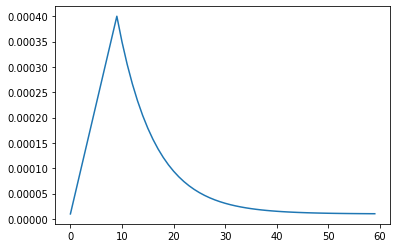

In [8]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 9
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .87

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [9]:
def get_model(base_model):
    base_model.trainable = True
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
    model.compile(
        optimizer='nadam',
        loss = 'categorical_crossentropy',
#         metrics=[tfa.metrics.F1Score(len(CLASSES), average='macro')],
        metrics=['accuracy'],
        # NEW on TPU in TensorFlow 24: sending multiple batches to the TPU at once saves communications
        # overheads and allows the XLA compiler to unroll the loop on TPU and optimize hardware utilization.
        steps_per_execution=16
    )
    return model

## EfficientNet B7

In [10]:
for i in range(len(Training_filenames)):
    
    print(f'Start training the fold{i} !')
    with strategy.scope():
        enet = efn.EfficientNetB7(weights='noisy-student', 
                                include_top=False,
                                pooling='avg',
                                input_shape=(*IMAGE_SIZE, 3))
        model1 = get_model(enet)
    

    chk_callback1 = tf.keras.callbacks.ModelCheckpoint(f'effnetb7_{i}_best.h5',
                                                       save_weights_only=True,
#                                                        monitor='val_f1_score',
                                                       monitor='val_accuracy',
                                                       mode='max',
                                                       save_best_only=True,
                                                       verbose=1)
    
    history1 = model1.fit(get_training_dataset(Training_filenames[i], do_onehot=True), 
                      steps_per_epoch=STEPS_PER_EPOCH, 
                      epochs=EPOCHS, 
                      validation_data=get_validation_dataset(Validation_filenames[i], do_onehot=True),
                      validation_steps=VALIDATION_STEPS,
                      callbacks=[lr_callback, chk_callback1],
                      verbose=2)

    del chk_callback1, history1, model1
    gc.collect()

Start training the fold0 !
258072576/258068648 [==============================] - 4s 0us/step
Epoch 1/60

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
114/114 - 426s - loss: 5.1841 - accuracy: 0.0090 - val_loss: 5.1717 - val_accuracy: 0.0117

Epoch 00001: val_accuracy improved from -inf to 0.01171, saving model to effnetb7_0_best.h5
Epoch 2/60

Epoch 00002: LearningRateScheduler reducing learning rate to 5.333333333333333e-05.
114/114 - 21s - loss: 5.0765 - accuracy: 0.0327 - val_loss: 4.8833 - val_accuracy: 0.1177

Epoch 00002: val_accuracy improved from 0.01171 to 0.11768, saving model to effnetb7_0_best.h5
Epoch 3/60

Epoch 00003: LearningRateScheduler reducing learning rate to 9.666666666666667e-05.
114/114 - 21s - loss: 4.0019 - accuracy: 0.1810 - val_loss: 2.7220 - val_accuracy: 0.3827

Epoch 00003: val_accuracy improved from 0.11768 to 0.38273, saving model to effnetb7_0_best.h5
Epoch 4/60

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000

## DenseNet201

In [11]:
for i in range(len(Training_filenames)):
    
    print(f'Start training the fold{i} !')
    with strategy.scope():
        densenet = tf.keras.applications.DenseNet201(weights='imagenet', 
                                                    include_top=False,
                                                    pooling='avg',
                                                    input_shape=(*IMAGE_SIZE, 3))
        model2 = get_model(densenet)

    chk_callback2 = tf.keras.callbacks.ModelCheckpoint(f'densenet201_{i}_best.h5',
                                                       save_weights_only=True,
#                                                        monitor='val_f1_score',
                                                       monitor='val_accuracy',
                                                       mode='max',
                                                       save_best_only=True,
                                                       verbose=1)
    
    history2 = model2.fit(get_training_dataset(Training_filenames[i], do_onehot=True), 
                      steps_per_epoch=STEPS_PER_EPOCH, 
                      epochs=EPOCHS, 
                      validation_data=get_validation_dataset(Validation_filenames[i], do_onehot=True),
                      validation_steps=VALIDATION_STEPS,
                      callbacks=[lr_callback, chk_callback2],
                      verbose=2)

    del chk_callback2, history2, model2
    gc.collect()

Start training the fold0 !
74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/60

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
114/114 - 377s - loss: 5.0854 - accuracy: 0.0291 - val_loss: 4.7265 - val_accuracy: 0.0651

Epoch 00001: val_accuracy improved from -inf to 0.06510, saving model to densenet201_0_best.h5
Epoch 2/60

Epoch 00002: LearningRateScheduler reducing learning rate to 5.333333333333333e-05.
114/114 - 12s - loss: 3.3242 - accuracy: 0.3554 - val_loss: 2.0975 - val_accuracy: 0.5083

Epoch 00002: val_accuracy improved from 0.06510 to 0.50831, saving model to densenet201_0_best.h5
Epoch 3/60

Epoch 00003: LearningRateScheduler reducing learning rate to 9.666666666666667e-05.
114/114 - 12s - loss: 1.7223 - accuracy: 0.6602 - val_loss: 1.0225 - val_accuracy: 0.7540

Epoch 00003: val_accuracy improved from 0.50831 to 0.75402, saving model to densenet201_0_best.h5
Epoch 4/60

Epoch 00004: LearningRateScheduler reducing learning rate t

# Predictions

In [12]:
def run_inference(modellist, model):
    test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.
    test_images_ds = test_ds.map(lambda image, idnum: image)
    predslist = []
    for modelpath in modellist:
        model.load_weights(modelpath)
        predslist.append(model.predict(test_images_ds,verbose=0, steps=TEST_STEPS))
    
    preds = np.sum(predslist, axis = 0)
    del model
    gc.collect()
    
    return preds

In [13]:
train = pd.read_csv('../input/classify-leaves/train.csv')
train.head()
leaves_labels = sorted(list(set(train['label'])))
n_classes = len(leaves_labels)
class_to_num = dict(zip(leaves_labels, range(n_classes)))
num_to_class = {v : k for k, v in class_to_num.items()}

In [14]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Calculating predictions...')
model1list = [f'./effnetb7_{i}_best.h5' for i in range(len(Training_filenames))]
model2list = [f'./densenet201_{i}_best.h5' for i in range(len(Training_filenames))]
model1 = get_model(enet)
model2 = get_model(densenet)
probs1 = run_inference(model1list,model1)
probs2 = run_inference(model2list,model2)
probabilities = 0.5*probs1 + 0.5*probs2
predictions = np.argmax(probabilities, axis=-1)

preds = []
for i in predictions:
    preds.append(num_to_class[i])

print('Generating submission file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, preds]), fmt=['%s', '%s'], delimiter=',', header='image,label', comments='')

Calculating predictions...
Generating submission file...
